# CNN Tuning - Taille du kernel - Extrême haut

Objectif : tester un modèle de réseau de neurones convolutionnel (CNN) en modifiant la taille des kernels des couches de convolution. En utilisant des tailles de kernels plus grandes que celles d'un modèle de référence, nous visons à évaluer l'impact de cette modification sur la performance de classification d'images de rayons X, en particulier pour détecter la pneumonie.

## Étapes Principales :

1. **Vérification de la disponibilité du GPU** : Un message s'affiche pour indiquer si l'entraînement se fera sur un GPU ou un CPU.
2. **Chargement des données** : Les images de rayons X sont chargées à partir des répertoires spécifiés pour les classes "PNEUMONIA" et "NORMAL".
3. **Prétraitement des données** : Les images sont normalisées et préparées pour l'entraînement.
4. **Visualisation de la distribution des données** : Un graphique montre le nombre d'images par classe.
5. **Création du modèle** : Un modèle CNN avec des couches de convolution utilisant des kernels de grande taille est défini.
6. **Validation croisée K-Fold** : Le modèle est entraîné et évalué sur plusieurs plis pour estimer sa précision.
7. **Évaluation des performances** : Les précisions des différents plis sont affichées et une conclusion est tirée sur l'adéquation des grandes tailles de kernels.

L'objectif final est de déterminer si les grandes tailles de kernels sont efficaces pour améliorer la précision de classification par rapport à un modèle de référence.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [6]:
img_size = 128
batch_size = 64
epochs = 7
n_folds = 10
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

Vérifie si un GPU est disponible pour l'entraînement de modèles en utilisant TensorFlow. Si un GPU est détecté, un message de confirmation est affiché. Sinon, un message indique que l'entraînement se fera sur le CPU.

In [8]:
def check_gpu():
    print("Vérification GPU...")
    if tf.config.list_physical_devices('GPU'):
        print("GPU détecté.")
    else:
        print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")

check_gpu()

Vérification GPU...
Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [10]:
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de la lecture de {img}. Passage au suivant.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [11]:
def preprocess_data(data):
    X = np.array([img[0] for img in data]).astype('float32') / 255
    y = np.array([img[1] for img in data])
    return X.reshape(len(X), img_size, img_size, 1), y

X_train, y_train = preprocess_data(data)

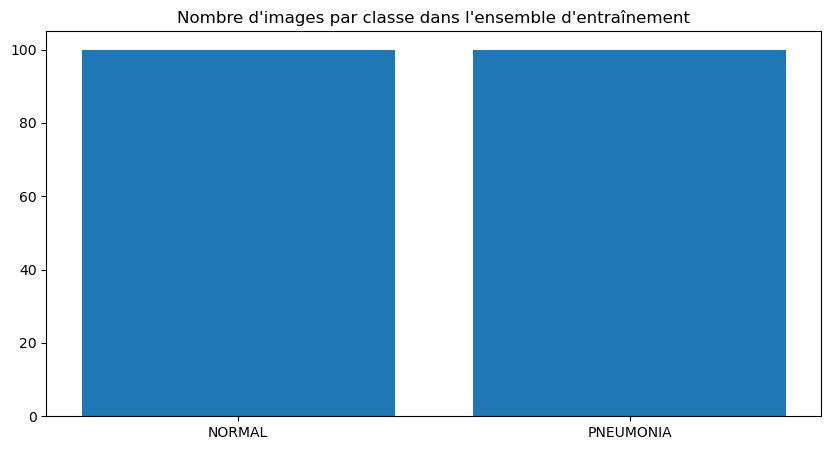

In [14]:
def visualize_data_distribution(y_train):
    plt.figure(figsize=(10, 5))
    plt.bar(['NORMAL', 'PNEUMONIA'], [len(y_train[y_train == 0]), len(y_train[y_train == 1])])
    plt.title('Nombre d\'images par classe dans l\'ensemble d\'entraînement')
    plt.show()

visualize_data_distribution(y_train)

In [16]:
def create_large_kernel_model():
    model = Sequential()
    model.add(Conv2D(32, (16, 16), input_shape=(img_size, img_size, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (16, 16), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (16, 16), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [18]:
def k_fold_validation(X_train, y_train):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

        print(f"Traitement du pli {fold + 1}/{n_folds}")
        datagen = ImageDataGenerator()
        train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
        valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

        model = create_large_kernel_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
        
        # Évaluer le modèle pour ce pli
        scores = model.evaluate(valid_generator, verbose=0)
        print(f"Précision de validation pour le pli {fold + 1}: {scores[1] * 100:.2f}%")
        fold_accuracies.append(scores[1])

    return fold_accuracies

fold_accuracies = k_fold_validation(X_train, y_train)

Traitement du pli 1/10
Epoch 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5044 - loss: 1.1723 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 2/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.5475 - loss: 0.6956 - val_accuracy: 0.5000 - val_loss: 0.8242
Epoch 3/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.5131 - loss: 0.7945 - val_accuracy: 0.5000 - val_loss: 0.6862
Epoch 4/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.4799 - loss: 0.6999 - val_accuracy: 0.5000 - val_loss: 0.6845
Epoch 5/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.4443 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 6/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.5408 - loss: 0.6887 - val_accuracy: 0.8500 - val_loss: 0.6755
Epoch 7/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.6573 - loss: 0.6685 - val_accuracy: 0.8000 - val_loss: 0.6378
Précision de validation pour le pli 1: 80.00%
Traitement du pli 2/10
Epoch 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step 

In [19]:
print(f"Précisions des plis : {fold_accuracies}")
print(f"Précision moyenne : {np.mean(fold_accuracies) * 100:.2f}%")

if np.mean(fold_accuracies) < 0.8:
    print("Conclusion : La précision est beaucoup plus faible que celle du modèle de référence, indiquant que les grandes tailles de kernels ne sont pas adaptées.")
else:
    print("La précision est acceptable, mais il est important de comparer avec le modèle de référence.")

Précisions des plis : [0.800000011920929, 0.550000011920929, 0.8500000238418579, 0.550000011920929, 0.6000000238418579, 0.550000011920929, 0.6000000238418579, 0.6000000238418579, 0.550000011920929, 0.44999998807907104]
Précision moyenne : 61.00%
Conclusion : La précision est beaucoup plus faible que celle du modèle de référence, indiquant que les grandes tailles de kernels ne sont pas adaptées.
